# `print(fiction)`

### Data Wrangling & Exploration

### _Tobias Reaper_



---

## Intro



---

### Imports and config

In [1]:
# === General Imports === #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# === ML Imports === #
# import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [4]:
# === Configure === #
%matplotlib inline
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

---

## Data Wrangling & Exploration

### Load and view basic data properties

Now that I have the dataset, I'm going to load it up, do some basic wrangling, and look at some basic summary statistics.

* Deal with nulls
* Remove any extraneous features
* Fix data types as needed

To start, I'm going to take care of null values. Then I'll remove some extraneous columns— features that won't be useful to the model.

In [5]:
# === Load the dataset === #
# This version is directly after scraping and preprocessing
data_path = "assets/must_read_books-01.csv"

books = pd.read_csv(data_path)
print(books.shape)
books.head(3)

(18573, 51)


,url,title,author,num_ratings,num_reviews,avg_rating,num_pages,language,original_publish_year,characters,series,places,asin,european_literature,memoir,fantasy,religion,horror,humor,historical_fiction,classics,adventure,autobiography,nonfiction,novels,biography,war,paranormal,historical,thriller,cultural,philosophy,childrens,literature,young_adult,mystery,science_fiction,contemporary,crime,history,romance,fiction,short_stories,publish_year,publish_month,publish_day,1_rating_count,2_rating_count,3_rating_count,4_rating_count,5_rating_count
0,https://www.goodreads.com/book/show/323355.The...,The Book of Mormon: Another Testament of Jesus...,Anonymous,71355.0,5704.0,4.37,531.0,English,1830.0,NaN,NaN,NaN,NaN,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2013.0,10.0,22.0,7520.0,2697.0,2521.0,1963.0,56654.0
1,https://www.goodreads.com/book/show/28862.The_...,The Prince,Niccolò Machiavelli,229715.0,7261.0,3.81,140.0,English,1513.0,"['Theseus (mythology)', 'Alexander the Great',...",NaN,NaN,NaN,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,True,False,True,False,False,False,False,False,True,False,False,False,2003.0,6.0,1.0,5254.0,16827.0,61182.0,80221.0,66231.0
2,https://www.goodreads.com/book/show/46654.The_...,The Foundation Trilogy,Isaac Asimov,83933.0,1331.0,4.40,679.0,English,1953.0,"['Hari Seldon', 'Salvor Hardin', 'Hober Mallow...",Foundation (Publication Order) #1-3,NaN,NaN,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,1974.0,1.0,1.0,477.0,1521.0,9016.0,25447.0,47472.0


In [6]:
# === Look at nulls === #
books.isnull().sum()

url                          0
title                        0
author                       0
num_ratings                  0
num_reviews                  0
avg_rating                   0
num_pages                  676
language                  1359
original_publish_year     6364
characters               12773
series                   11788
places                   13389
asin                     15946
european_literature          0
memoir                       0
fantasy                      0
religion                     0
horror                       0
humor                        0
historical_fiction           0
classics                     0
adventure                    0
autobiography                0
nonfiction                   0
novels                       0
biography                    0
war                          0
paranormal                   0
historical                   0
thriller                     0
cultural                     0
philosophy                   0
children

Looking at the dataset, I can see immediately that I'll have to convert the Boolean features to binary. Beyond that, however, most of the cleaning was done while it was being gathered or directly afterwards. All of the other data types are fine.

There are a few columns in the data that I can see won't be relevant to the model:

* url
* asin
* characters
* places

'url' and 'asin' are obviously not going to be useful, just extra noise. As far as the other two, 'characters' and 'places', I'm basing my decision to remove them on my domain knowledge—nonfiction books are much less likely to be set in a location or have characters—and on the quality of their data. Both have a high proportion of null values—over 50%—and I cannot be sure whether the null values represent the fact that users simply haven't taken the time to add that data to those books, or if those books really do not have any significant characters or places.

In [8]:
# === Replace Boolean values with binary === #
books = books.replace(to_replace={True: 1, False:0})

In [9]:
# === Drop extraneous features === #
drop_cols = [
    "url",
    "asin",
    "characters",
    "places",
]

books = books.drop(columns=drop_cols)

Now to deal with the null values throughout the rest of the dataset:

* `num_pages                  676`
  * Impute using mean or median
* `language                  1359`
  * Impute using mode
  * "English" class is the largest class by a long shot
* `original_publish_year     6364`
  * Nulls can be assumed to indicate that 
* `characters               12773`
* `series                   11788`
* `publish_year               284`
* `publish_month              284`
* `publish_day                284`
* `1_rating_count              83`
* `2_rating_count              83`
* `3_rating_count              83`
* `4_rating_count              83`
* `5_rating_count              83`

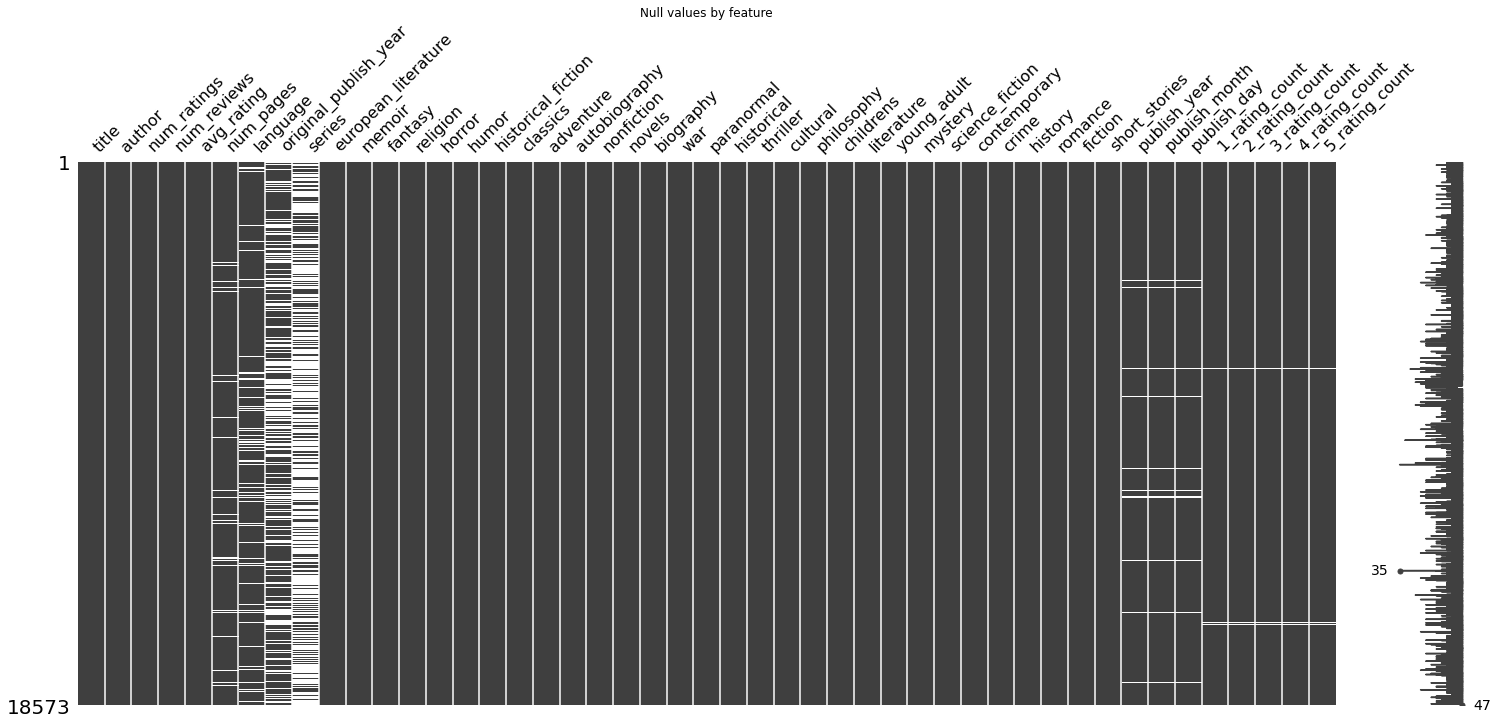

In [20]:
# === Use missingno to visualize nulls === #
import missingno as msno

msno.matrix(books)
plt.title("Null values by feature")
# plt.tight_layout()
# plt.savefig("null_values_by_feature.png", dpi=80)

In [13]:
# === Look at value counts of 'language' === #
# Given the size of English compared with the other classes,
# it can fill in the nulls. i.e. impute using the mode.
books["language"].value_counts().head()

English    15909
Arabic       205
Spanish      178
French       104
German        89
Name: language, dtype: int64

In [11]:
# === Look at categorical features === #
books.describe(exclude="number").T.sort_values(by="unique")

,count,unique,top,freq
language,17214,55,English,15909
series,6785,6423,Disney's Wonderful World of Reading,8
author,18573,10019,Stephen King,79
title,18573,17816,The Nightingale,6


In [9]:
# === Drop null values === #
books = books.dropna(axis="index")
bvalue_countsll().sum()

title                    0
author                   0
num_ratings              0
num_reviews              0
avg_rating               0
num_pages                0
fiction                  0
short_stories            0
publish_year             0
publish_month            0
publish_day              0
1_rating_count           0
2_rating_count           0
3_rating_count           0
4_rating_count           0
5_rating_count           0
in_series                0
the_title                0
has_subtitle             0
title_char_count         0
title_word_count         0
title_longest_word       0
author_name_count        0
author_middle_initial    0
rating_ratio_1_5         0
dtype: int64

In [4]:
# === Basic descriptive statistics of numeric data === #
books.describe().T

,count,mean,std,min,25%,50%,75%,max
num_ratings,18573.0,46958.564906,212398.096869,0.0,387.00,4135.00,23108.00,6144613.0
num_reviews,18573.0,2289.266247,7681.862032,0.0,41.00,271.00,1380.00,163981.0
avg_rating,18573.0,4.029929,0.303335,0.0,3.84,4.04,4.22,5.0
num_pages,17897.0,340.212661,249.007716,0.0,221.00,307.00,402.00,8124.0
publish_year,18289.0,2005.629231,10.709413,1816.0,2001.00,2008.00,2013.00,2019.0
publish_month,18289.0,6.689650,3.411024,1.0,4.00,7.00,10.00,12.0
publish_day,18289.0,13.731423,10.042377,1.0,3.00,14.00,23.00,31.0
1_rating_count,18490.0,1049.250135,6484.347528,0.0,7.00,70.00,383.00,509660.0
2_rating_count,18490.0,2270.299459,10177.791045,0.0,19.00,202.00,1080.00,497885.0
3_rating_count,18490.0,8248.047864,32751.345253,0.0,72.00,829.00,4465.75,916924.0


In [71]:
books.head()

,title,author,num_ratings,num_reviews,avg_rating,num_pages,language,european_literature,memoir,fantasy,religion,horror,humor,historical_fiction,classics,adventure,autobiography,nonfiction,novels,biography,war,paranormal,historical,thriller,cultural,philosophy,childrens,literature,young_adult,mystery,science_fiction,contemporary,crime,history,romance,fiction,short_stories,publish_year,publish_month,publish_day,1_rating_count,2_rating_count,3_rating_count,4_rating_count,5_rating_count,in_series,has_charlist,has_setting
0,The Book of Mormon: Another Testament of Jesus...,Anonymous,71355.0,5704.0,4.37,531.0,English,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2013.0,10.0,22.0,7520.0,2697.0,2521.0,1963.0,56654.0,0,0,0
1,The Prince,Niccolò Machiavelli,229715.0,7261.0,3.81,140.0,English,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,2003.0,6.0,1.0,5254.0,16827.0,61182.0,80221.0,66231.0,0,1,0
2,The Foundation Trilogy,Isaac Asimov,83933.0,1331.0,4.40,679.0,English,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1974.0,1.0,1.0,477.0,1521.0,9016.0,25447.0,47472.0,1,1,0
3,From the Mixed-Up Files of Mrs. Basil E. Frank...,E.L. Konigsburg,173617.0,6438.0,4.15,178.0,English,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,2003.0,6.0,2.0,2742.0,6381.0,29358.0,58559.0,76577.0,0,1,1
4,A Room of One's Own,Virginia Woolf,98164.0,5848.0,4.14,112.0,English,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2000.0,1.0,1.0,1357.0,3778.0,15993.0,35876.0,41160.0,0,0,0


---

## Exploration & Visualization

In [10]:
# === See resulting shape === #
books.shape

(18047, 25)

### Distributions and outliers

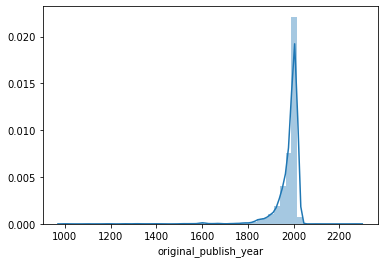

In [16]:
# === Distribution of 'original_publish_year' === #
sns.distplot(books["original_publish_year"]);

### Visualizing outliers

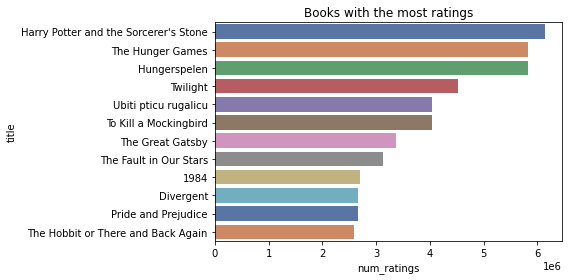

In [41]:
# === Books with the most ratings === #
hiratings = books.nlargest(20, ["num_ratings"]).set_index("title")["num_ratings"]
plt.figure(figsize=(8, 4))
sns.barplot(hiratings, hiratings.index, palette="deep")
plt.title("Books with the most ratings");
plt.tight_layout()
plt.savefig("books_most_ratings.png", dpi=160)

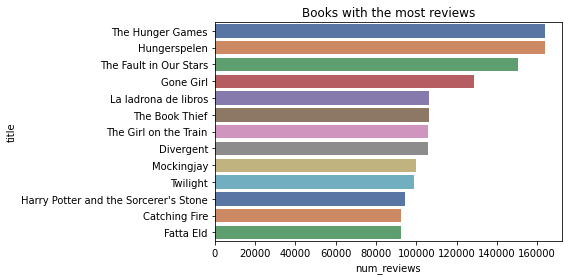

In [59]:
# Books with the most reviews
hireviews = books.nlargest(24, ["num_reviews"]).set_index("title")["num_reviews"]
plt.figure(figsize=(8, 4))
sns.barplot(hireviews, hireviews.index, palette="deep")
plt.title("Books with the most reviews")
plt.tight_layout();
plt.savefig("books_most_reviews.png", dpi=160)

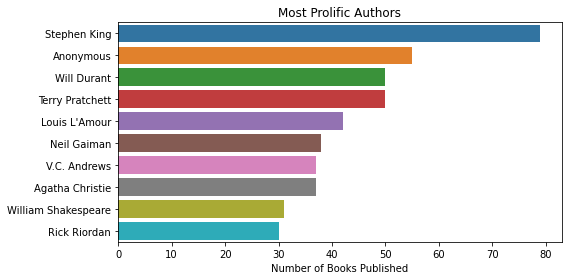

In [61]:
# Most prolific authors
prolifics = books["author"].value_counts().head(10)
plt.figure(figsize=(8, 4))
sns.barplot(prolifics, prolifics.index)
plt.title("Most Prolific Authors")
plt.tight_layout()
plt.xlabel("Number of Books Published");
plt.savefig("authors_most_books.png", dpi=160)

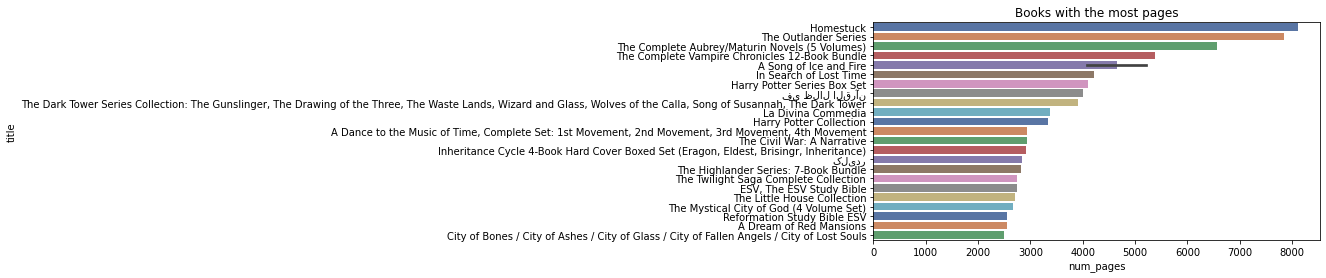

In [62]:
# === Books with the most pages === #
hipages = books.nlargest(24, ["num_pages"]).set_index("title")["num_pages"]
plt.figure(figsize=(8, 4))
sns.barplot(hipages, hipages.index, palette="deep")
plt.title("Books with the most pages");
# plt.savefig("books_most_pages.png", dpi=160)

In [63]:
hipages

title
Homestuck                                                                                                                                                               8124.0
The Outlander Series                                                                                                                                                    7852.0
The Complete Aubrey/Maturin Novels (5 Volumes)                                                                                                                          6576.0
The Complete Vampire Chronicles 12-Book Bundle                                                                                                                          5392.0
A Song of Ice and Fire                                                                                                                                                  5216.0
In Search of Lost Time                                                                                                 

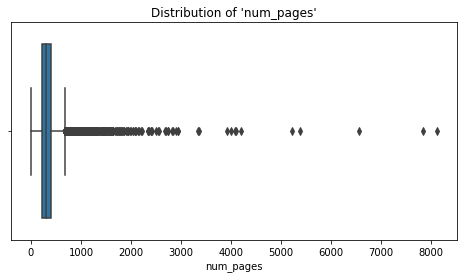

In [51]:
# === Boxplot to view outliers === #
plt.figure(figsize=(8, 4))
sns.boxplot(x=books["num_pages"])
plt.title("Distribution of 'num_pages'");
plt.savefig("num_pages_boxplot.png", dpi=160)

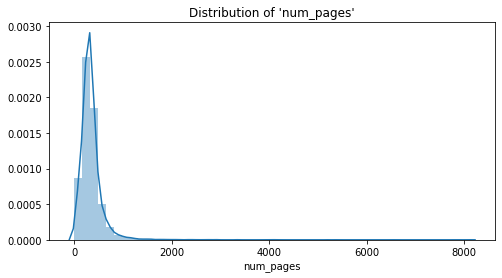

In [50]:
# === Distribution plot === #
plt.figure(figsize=(8, 4))
sns.distplot(books["num_pages"])
plt.title("Distribution of 'num_pages'");
plt.savefig("num_pages_distplot.png", dpi=160)

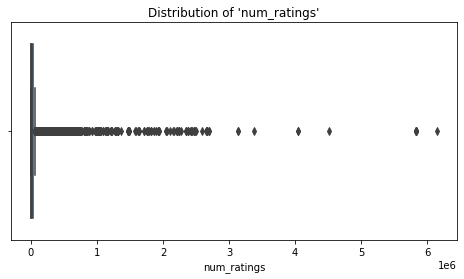

In [52]:
# === Boxplot to view outliers === #
plt.figure(figsize=(8, 4))
sns.boxplot(x=books["num_ratings"])
plt.title("Distribution of 'num_ratings'");
plt.savefig("num_ratings_boxplot.png", dpi=160)

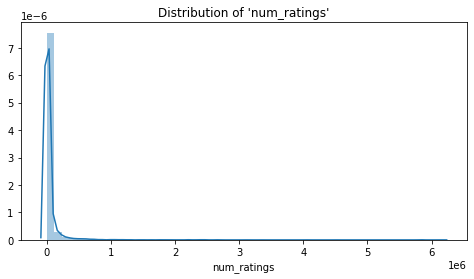

In [53]:
# === Distribution === #
plt.figure(figsize=(8, 4))
sns.distplot(books["num_ratings"])
plt.title("Distribution of 'num_ratings'");
plt.savefig("num_ratings_distplot.png", dpi=160)

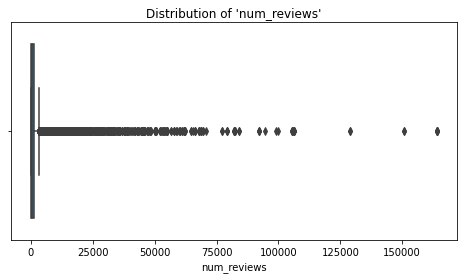

In [54]:
# To find outliers in numerical features, utilize boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x=books["num_reviews"])
plt.title("Distribution of 'num_reviews'");
plt.savefig("num_reviews_boxplot.png", dpi=160)

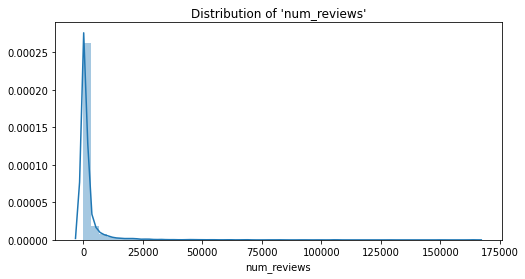

In [55]:
plt.figure(figsize=(8, 4))
sns.distplot(books["num_reviews"])
plt.title("Distribution of 'num_reviews'");
plt.savefig("num_reviews_distplot.png", dpi=160)

### Removing outliers

In [66]:
# See how much removing pages outliers affects dataset
# This could even be one of the sliders on the app
cutoff = 3000
books_pages = books[books["num_pages"] <= cutoff]
print(f"There are {books.shape[0] - books_pages.shape[0]} books above {cutoff} pages long.")
print(f"The resulting dataset has {books_pages.shape[0]} rows.")

There are 688 books above 3000 pages long.
The resulting dataset has 17885 rows.


In [68]:
# === Glance at the books over 3000 pages long === #
books_over_cutoff = books[books["num_pages"] > cutoff]
print(books_over_cutoff.shape)
books_over_cutoff

(12, 48)


,title,author,num_ratings,num_reviews,avg_rating,num_pages,language,european_literature,memoir,fantasy,religion,horror,humor,historical_fiction,classics,adventure,autobiography,nonfiction,novels,biography,war,paranormal,historical,thriller,cultural,philosophy,childrens,literature,young_adult,mystery,science_fiction,contemporary,crime,history,romance,fiction,short_stories,publish_year,publish_month,publish_day,1_rating_count,2_rating_count,3_rating_count,4_rating_count,5_rating_count,in_series,has_charlist,has_setting
271,In Search of Lost Time,Marcel Proust,9249.0,515.0,4.34,4211.0,English,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,2003.0,6.0,3.0,249.0,365.0,965.0,2045.0,5625.0,1,0,0
373,A Song of Ice and Fire,George R.R. Martin,43149.0,1011.0,4.63,4081.0,English,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2011.0,3.0,22.0,248.0,469.0,2168.0,9267.0,30997.0,1,0,0
1575,Harry Potter Series Box Set,J.K. Rowling,233318.0,7048.0,4.74,4100.0,English,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,2007.0,10.0,1.0,1434.0,1536.0,7828.0,34119.0,188401.0,1,0,0
3519,The Dark Tower Series Collection: The Gunsling...,Stephen King,9285.0,343.0,4.61,3914.0,English,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,2011.0,7.0,22.0,100.0,134.0,524.0,1788.0,6739.0,1,0,0
3754,A Song of Ice and Fire,George R.R. Martin,46238.0,1549.0,4.63,5216.0,English,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,2011.0,7.0,22.0,296.0,510.0,2342.0,9913.0,33177.0,1,1,0
6745,Homestuck,Andrew Hussie,1280.0,182.0,4.67,8124.0,English,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,2016.0,4.0,13.0,25.0,13.0,56.0,170.0,1016.0,1,0,0
6867,The Outlander Series,Diana Gabaldon,8271.0,414.0,4.73,7852.0,English,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,2012.0,10.0,29.0,44.0,62.0,309.0,1246.0,6610.0,1,0,0
9649,La Divina Commedia,Dante Alighieri,103704.0,3390.0,4.07,3367.0,Italian,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,2007.0,10.0,23.0,1555.0,5196.0,20328.0,34366.0,42259.0,1,1,0
11296,Harry Potter Collection,J.K. Rowling,29527.0,920.0,4.73,3342.0,English,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,2005.0,9.0,12.0,250.0,209.0,1040.0,4268.0,23760.0,1,0,0
12270,في ظلال القرآن,Sayed Qutb,3312.0,135.0,4.52,4012.0,Arabic,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2008.0,10.0,23.0,102.0,65.0,230.0,536.0,2379.0,1,0,0


In [27]:
# See how much removing ratings outliers affects dataset
cutoff = 1940
df6 = df5[df5["publish_year"] >= cutoff]
print(f"There are {df5.shape[0] - df6.shape[0]} books published before {cutoff}.")
print(f"The resulting dataset has {df6.shape[0]} rows.")

There are 216 books published before 1940.
The resulting dataset has 16960 rows.


#### Distribution of target

The distribution, or skew, of the target variable will help determine the best choice of model metric. If the target is wildly skewed one way or another, accuracy is not a good measure of how well a classification model is performing.

In this case, the distribution of the binary target `fiction` was relatively equally distributed between the two  classes.

In [13]:
# === Distribution of target === #
books["fiction"].value_counts()

1    9745
0    8828
Name: fiction, dtype: int64